# Testing out PyTorch

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from kmeans_pytorch import kmeans, kmeans_predict
import rioxarray as rxr
import pandas as pd
import earthpy.plot as ep
import geopandas as gpd
import matplotlib.pyplot as plt
import itertools
import cv2 as cv
import os
from matplotlib import colors as colors_mat
import matplotlib.patches as mpatches
import matplotlib.cm as cm

In [7]:
aoi_list = ['coast_NW', 'coast_N', 'horn', 'coast_W', 'marsh_E', 'marsh_W']
#aoi_list = ['west','east','barrier', 'coast_marsh_S']

def aoi_path(name):
    return '../shapefiles/'+name+'.shp'

In [8]:
dir = '../Planet/'
#dir = '../Planet_Caracol/'
times = []
sites = []
resSites = []
unmasked_sites = []
for area in aoi_list:
    unmasked_obs = []
    obs = []
    res = []
    aoi = gpd.read_file(aoi_path(area))
    for entry in os.scandir(dir):
        times.append(entry.path)
        ob = rxr.open_rasterio(entry.path).rio.clip(aoi.geometry, from_disk=True).squeeze()
        ob_copy = rxr.open_rasterio(entry.path).rio.clip(aoi.geometry, from_disk=True).squeeze()
        res.append(ob.rio.resolution()[0])
        obs.append(ob)
        unmasked_obs.append(ob_copy)
    sites.append(obs)
    unmasked_sites.append(unmasked_obs)
    resSites.append(res)

In [9]:
reshapedSites = []
for site in sites:
    acqVecs = []
    reshapedVecs = []
    shapes = []
    for ob in site:
        shapes.append(ob.shape)
        acq = [band.values.reshape(((band.shape)[0])*((band.shape)[1]), 1) for band in ob]
        acqVecs.append(acq)
    for i, acq in enumerate(acqVecs):
        resh = np.array(acq).reshape(shapes[i][0], shapes[i][1]*shapes[i][2]).transpose()
        reshapedVecs.append(resh)
    reshapedSites.append(reshapedVecs)

In [10]:
# set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
x = torch.from_numpy(reshapedSites[3][-1])

In [12]:
cluster_ids_x, cluster_centers = kmeans(X=x, num_clusters=3, distance='euclidean', device=device)

running k-means on cuda..


[running kmeans]: 40it [00:03, 10.14it/s, center_shift=0.000052, iteration=40, tol=0.000100]    


In [13]:
# more data
y = torch.from_numpy(reshapedSites[3][-1])

In [14]:
# predict cluster ids for y
cluster_ids_y = kmeans_predict(
    y, cluster_centers, 'euclidean', device=device
)

predicting on cuda..


In [15]:
cluster_ids_y.shape

torch.Size([774795])

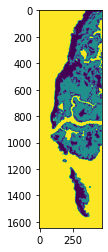

In [16]:
clusteredImage = cluster_ids_y.reshape(sites[3][-1][0].shape)
plt.imshow(clusteredImage)

In [20]:
cluster_centers

tensor([[ 395.8225,  613.0710,  575.4420, 1566.5151],
        [ 134.4457,  330.0593,  200.1522, 2281.7698],
        [ 242.9789,  320.8815,  162.5287,  160.3441]])